# Movement detection by cross correlation of points

The basic idea is that we could buffer the detected normalized unrotated (DNU) points, henceforth called DNUV (V for video). If we compare, after each frame, the DNUV with the DNUV reference using the normalized cross reference, we would get, in case of a match, a value that is between 0 and 1 and close to one. Do that for every DNUV reference and we basically return to the same approach of the static gestures, where the match is the one that has greather value. 

We would have to consider that each point has its own 3D signal, run the cross reference evaluation in each of the signal and average all the cross references.

The point of using cross reference is that it is invariant to time shifts, which should be the only valid difference of a matched DNUV reference and an incoming DNUV.

The plan for this Jupyter Notebook is to first test if this is a valid idea, with simple 1D functions in time. Afterwards, in case of success in this simple case, we'll delve into exploring 2D and 3D functions in time (should produce some pretty videos). Then the idea is to try using a poorly sampled function with interpolation to account for fails in sensing. If that goes nice, a final test will be done using the full hand signals from mediapipe.

## 1D Function matching using cross correlation

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from scipy import interpolate
import mediapipe as mp
from datetime import datetime
import cv2
import time
from gesture.base import Gesture, hand_frame_of_reference
import pandas as pd
from scipy import stats
from tslearn.metrics import dtw, dtw_path_from_metric

Let's generate two simple functions that are equal and calculate the average cross correlation. First we'll implement a function that calculates the average cross correlation given two signals.

In [347]:
def sbd(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Signal based distance (SBD) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.

    Returns
    -------
    sbd : float
    """
    a = (a - np.mean(a)) / np.std(a)
    b = (b - np.mean(b)) / np.std(b)
    # a = a / a.max()
    # b = b / b.max()
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        norm_corr = 0
    else:
        norm_corr = np.correlate(a, b, mode="full") / (
            np.linalg.norm(a) * np.linalg.norm(b)
        )
    return 1 - np.max(np.abs(norm_corr))

In [348]:
def mncc(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Maximum normalized cross-correlation (MNCC) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.

    Returns
    -------
    np.ndarray
        Maximum normalized cross-correlation between the two signals.
    """
    a = a - np.mean(a)
    b = b - np.mean(b)
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        ncc = np.correlate(a, b, mode="full")
    else:
        ncc = np.correlate(a, b, mode="full") / (np.linalg.norm(a) * np.linalg.norm(b))
    return ncc.max()

In [349]:
def incc(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Integrated normalized cross-correlation (INCC) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.

    Returns
    -------
    np.ndarray
        Integrated normalized cross-correlation between the two signals.
    """
    a = a - np.mean(a)
    b = b - np.mean(b)
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        ncc = np.correlate(a, b, mode="full")
        ncca = np.correlate(a, a, mode="full")
        nccb = np.correlate(b, b, mode="full")
    else:
        ncc = np.correlate(a, b, mode="full") / (np.linalg.norm(a) * np.linalg.norm(b))
        ncca = np.correlate(a, a, mode="full") / (np.linalg.norm(a) * np.linalg.norm(a))
        nccb = np.correlate(b, b, mode="full") / (np.linalg.norm(b) * np.linalg.norm(b))
    incc = np.trapz(np.abs(ncc))
    # incc isn't between 0 and 1, so we normalize it by the incc of a with itself
    incca = np.trapz(np.abs(ncca))
    inccb = np.trapz(np.abs(nccb))
    inccd = np.max([incca, inccb])
    if inccd == 0:
        return incc
    else:
        return incc / inccd

Now testing with two exactly equal signals

INCC(a, a) = 1.0


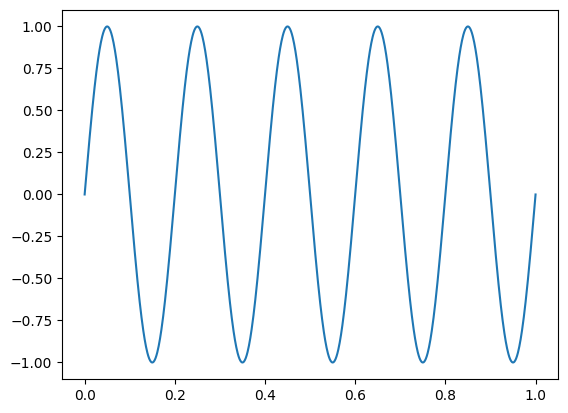

In [350]:
t = np.linspace(0, 1, 1000)
a = np.sin(2 * np.pi * 5 * t)
plt.plot(t, a)
ncc = incc(a, a)
print(f"INCC(a, a) = {ncc}")

And using noise

INCC(a, a_noise) = 0.9898821364472273
MNCC(a, a_noise) = 0.989861569836313
SBD(a, a_noise) = 0.010138430163686984


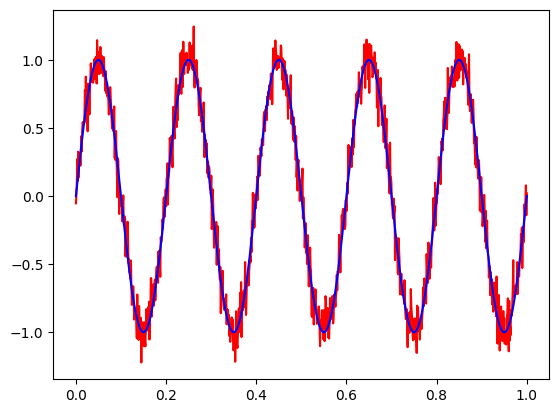

In [351]:
noise_level = 0.1
a_noise = a + noise_level * np.random.randn(a.shape[0])
plt.plot(t, a_noise, color="red")
plt.plot(t, a, color="blue")
ncc = incc(a, a_noise)
print(f"INCC(a, a_noise) = {ncc}")
print(f"MNCC(a, a_noise) = {mncc(a, a_noise)}")
print(f"SBD(a, a_noise) = {sbd(a, a_noise)}")

Which shows that even with high noise_levels (play around with it) we get a very decent value that is possible to use in signal matching.

Let's try with translations!

First a function to ease shifts

In [352]:
def shift_signal(
    t: np.ndarray, a: np.ndarray, shift: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Shifts a signal (to the right) by a given amount.

    Parameters
    ----------
    t : np.ndarray
        Time points of the signal.
    a : np.ndarray
        Signal to shift.
    shift : float
        Amount (of time) to shift the signal by.

    Returns
    -------
    t_shifted: np.ndarray
        Shifted time points.
    a_shifted: np.ndarray
        Shifted signal.
    """
    t_shifted = np.arange(-shift, t[-1], t[1] - t[0])
    a_shifted = np.concatenate((a, np.zeros(t_shifted.shape[0] - t.shape[0])), axis=0)
    return t_shifted, a_shifted


def shift_signal_left(
    t: np.ndarray, a: np.ndarray, shift: float
) -> tuple[np.ndarray, np.ndarray]:
    """
    Shifts a signal (to the left) by a given amount.

    Parameters
    ----------
    t : np.ndarray
        Time points of the signal.
    a : np.ndarray
        Signal to shift.
    shift : float
        Amount (of time) to shift the signal by.

    Returns
    -------
    t_shifted: np.ndarray
        Shifted time points.
    a_shifted: np.ndarray
        Shifted signal.
    """
    t_shifted = np.concatenate(
        (t, np.arange(t[-1] + t[1] - t[0], t[-1] + shift, t[1] - t[0])), axis=0
    )
    a_shifted = np.concatenate((a, np.zeros(t_shifted.shape[0] - t.shape[0])), axis=0)
    return t_shifted, a_shifted

Now testing with right and left shifts

INCC(a, a_shifted) = 1.0
MNCC(a, a_shifted) = 1.0
SBD(a, a_shifted) = 2.220446049250313e-16
SBD(a, a_scaled) = 0.013463183858320349


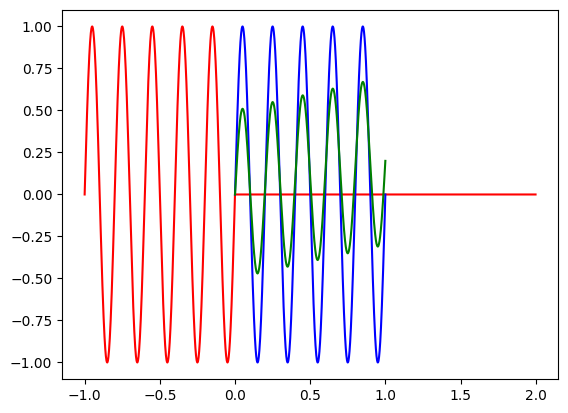

In [357]:
shift = 1
t_shifted, a_shifted = shift_signal(t, a, shift)
t_shifted, a_shifted = shift_signal_left(t_shifted, a_shifted, shift)
a_scaled = a * 0.5 + 0.2*t
plt.plot(t_shifted, a_shifted, color="red")
plt.plot(t, a, color="blue")
plt.plot(t, a_scaled, color="green")
print(f"INCC(a, a_shifted) = {incc(a, a_shifted)}")
print(f"MNCC(a, a_shifted) = {mncc(a, a_shifted)}")
print(f"SBD(a, a_shifted) = {sbd(a, a_shifted)}")
print(f"SBD(a, a_scaled) = {sbd(a, a_scaled)}")

And with noisy shifts

MNCC(a, a_shifted) = 0.9716864287295985
INCC(a, a_shifted) = 0.9865503455017064
SBD(a, a_shifted) = 0.028313571270401572


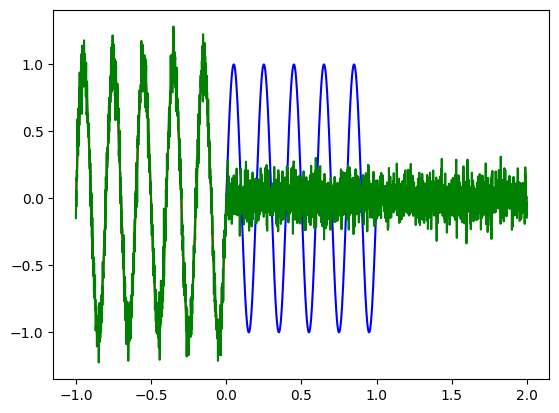

In [210]:
noise_level = 0.1
a_shifted_noise = a_shifted + noise_level * np.random.randn(a_shifted.shape[0])
plt.plot(t_shifted, a_shifted, color="red")
plt.plot(t, a, color="blue")
plt.plot(t_shifted, a_shifted_noise, color="green")
print(f"MNCC(a, a_shifted) = {mncc(a, a_shifted_noise)}")
print(f"INCC(a, a_shifted) = {incc(a, a_shifted_noise)}")
print(f"SBD(a, a_shifted) = {sbd(a, a_shifted_noise)}")


Even with noisy shifts the MNCC indicator is a good matching index!

Although it suffers more with noise when the shifts are larger, this is due to the fact that in that case, the gross amount of the signal's energy is in noise. Hopefully our signals aren't that noisy, if they are, we can always filter. 

### Can we match 1D signals that have complex shapes?

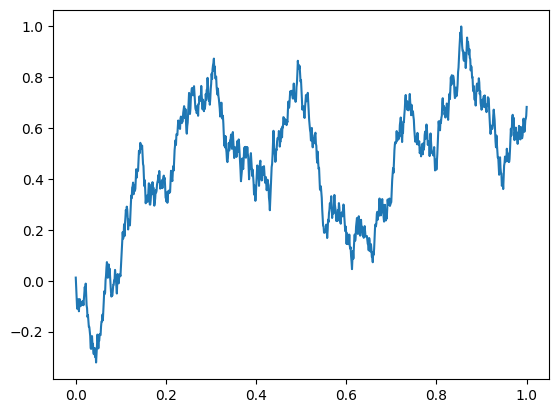

In [211]:
seed = np.random.rand(1000) - 0.5
signal_base = np.cumsum(seed)
signal_base /= np.max(np.abs(signal_base))  # Normalize
t = np.linspace(0, 1, 1000)
plt.plot(t, signal_base)

Let's calculate the similarity with a shifted version of it.

MNCC(signal_base, signal_sifted) = 0.5849813763441797
INCC(signal_base, signal_sifted) = 0.3228275312770028
INCC(signal_siifted, signal_base) = 0.3228275312770028
INCC(signal_base, signal_base) = 1.0
SBD(signal_base, signal_sifted) = 0.41501862365581677


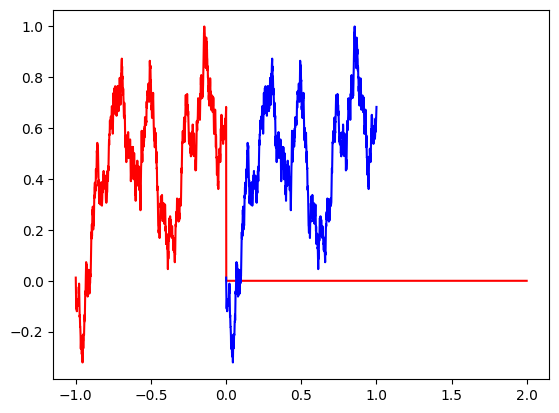

In [212]:
t_shifted, signal_sifted = shift_signal(t, signal_base, 1)
t_shifted, signal_sifted = shift_signal_left(t_shifted, signal_sifted, 1)
plt.plot(t_shifted, signal_sifted, color="red")
plt.plot(t, signal_base, color="blue")
print(f"MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}")
print(f"INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}")
print(f"INCC(signal_siifted, signal_base) = {incc(signal_sifted, signal_base)}")
print(f"INCC(signal_base, signal_base) = {incc(signal_base, signal_base)}")
print(f"SBD(signal_base, signal_sifted) = {sbd(signal_base, signal_sifted)}")

Which the same effectiveness. Let's try a vertical shift!

MNCC(signal_base, signal_sifted) = 0.5849813763441796
INCC(signal_base, signal_sifted) = 0.32282753127700275
SBD(signal_base, signal_sifted) = 0.41501862365581677


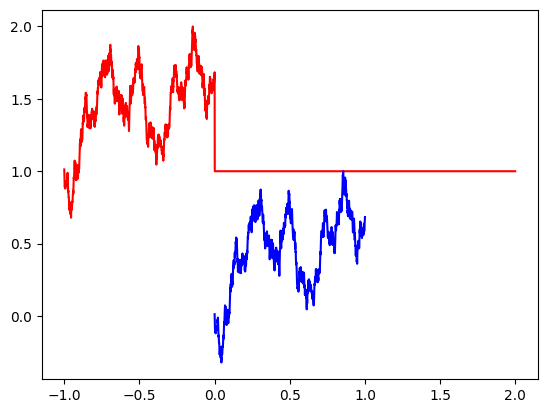

In [213]:
signal_sifted += 1
plt.plot(t_shifted, signal_sifted, color="red")
plt.plot(t, signal_base, color="blue")
print(f"MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}")
print(f"INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}")
print(f"SBD(signal_base, signal_sifted) = {sbd(signal_base, signal_sifted)}")

Which is exactly the same MNCC!

With noise...

MNCC(signal_base, signal_sifted) = 0.5450451131462852
INCC(signal_base, signal_sifted) = 0.3536735315563907
SBD(signal_base, signal_sifted) = 0.45495488685371477


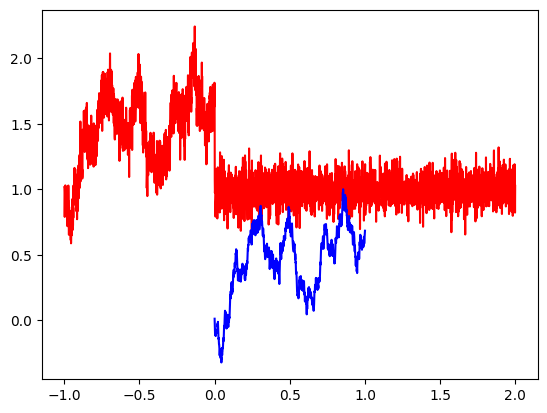

In [214]:
noise_level = 0.1
signal_sifted += noise_level * np.random.randn(signal_sifted.shape[0])
plt.plot(t_shifted, signal_sifted, color="red")
plt.plot(t, signal_base, color="blue")
print(f"MNCC(signal_base, signal_sifted) = {mncc(signal_base, signal_sifted)}")
print(f"INCC(signal_base, signal_sifted) = {incc(signal_base, signal_sifted)}")
print(f"SBD(signal_base, signal_sifted) = {sbd(signal_base, signal_sifted)}")

Which works just as fine as before.

## Matching 2D lines 

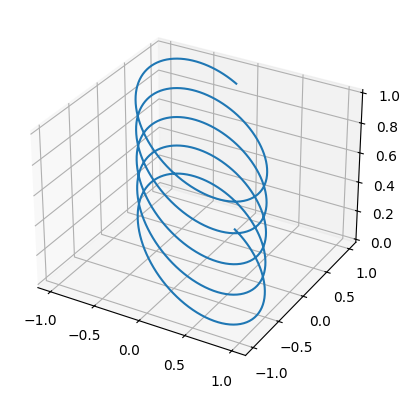

In [215]:
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * 5 * t)  # Signal x coordinate
y = np.cos(2 * np.pi * 5 * t + np.pi / 4)  # Signal y coordinate
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, t)

Comparing with a shifted version of it

Mean MNCC = 0.9999997727499503
Mean INCC = 0.9999947219418199
Mean SBD = 2.2725004972246055e-07


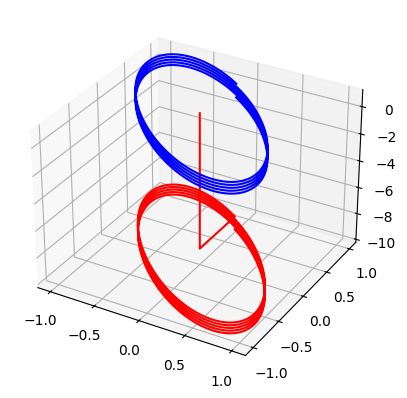

In [216]:
t_shifted, x_shifted = shift_signal(t, x, 10)
t_shifted, y_shifted = shift_signal(t, y, 10)
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x_shifted, y_shifted, t_shifted, color="red")
ax.plot(x, y, t, color="blue")
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f"Mean MNCC = {mean_mncc}")
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f"Mean INCC = {mean_incc}")
mean_sbd = (sbd(x, x_shifted) + sbd(y, y_shifted)) / 2
print(f"Mean SBD = {mean_sbd}")

Which works just as fine in 2D as in 1D. Let's try with other shifts.

Mean MNCC = 0.9999997727499503
Mean INCC = 0.9999947219418199
Mean SBD = 2.2725004972246055e-07


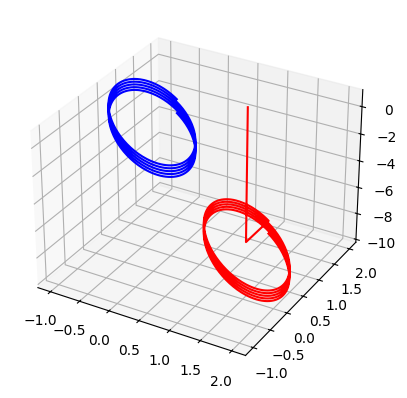

In [217]:
x_shifted += 1
y_shifted += 1
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x_shifted, y_shifted, t_shifted, color="red")
ax.plot(x, y, t, color="blue")
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f"Mean MNCC = {mean_mncc}")
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f"Mean INCC = {mean_incc}")
mean_sbd = (sbd(x, x_shifted) + sbd(y, y_shifted)) / 2
print(f"Mean SBD = {mean_sbd}")

Works amazingly well. Noise?

Mean MNCC = 0.9734142769257291
Mean INCC = 0.998071779424476
Mean SBD = 0.02658572307427065


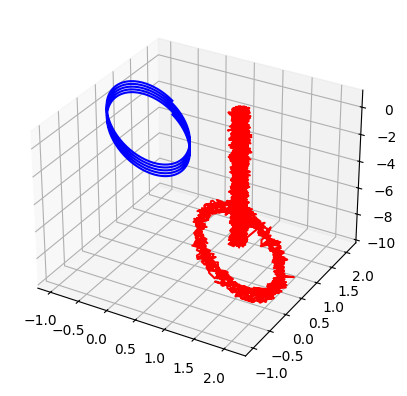

In [218]:
noise_level = 0.05
x_shifted += noise_level * np.random.randn(x_shifted.shape[0])
y_shifted += noise_level * np.random.randn(y_shifted.shape[0])
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x_shifted, y_shifted, t_shifted, color="red")
ax.plot(x, y, t, color="blue")
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted)) / 2
print(f"Mean MNCC = {mean_mncc}")
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted)) / 2
print(f"Mean INCC = {mean_incc}")
mean_sbd = (sbd(x, x_shifted) + sbd(y, y_shifted)) / 2
print(f"Mean SBD = {mean_sbd}")


Kinda impressive...

What about two different signals? What's the Mean MNCC?

Mean MNCC = 0.11876081850385237
Mean INCC = 0.18253548087659555
Mean SBD = 0.8459914374453865


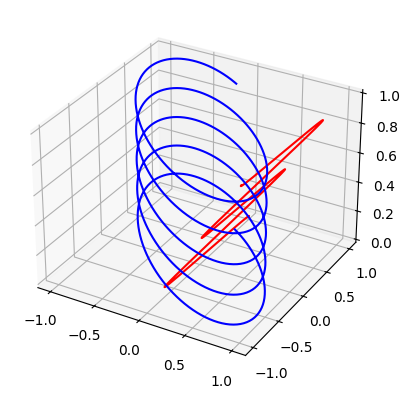

In [219]:
x_d = t * 1
y_d = np.cos(1 * np.pi * 5 * t)  # Signal y coordinate
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x_d, y_d, t, color="red")
ax.plot(x, y, t, color="blue")
mean_mncc = (mncc(x, x_d) + mncc(y, y_d)) / 2
print(f"Mean MNCC = {mean_mncc}")
mean_incc = (incc(x, x_d) + incc(y, y_d)) / 2
print(f"Mean INCC = {mean_incc}")
mean_sbd = (sbd(x, x_d) + sbd(y, y_d)) / 2
print(f"Mean SBD = {mean_sbd}")

Fairly different shapes do indeed have different MMNCC. Amazing!!!!

## 3D Lines

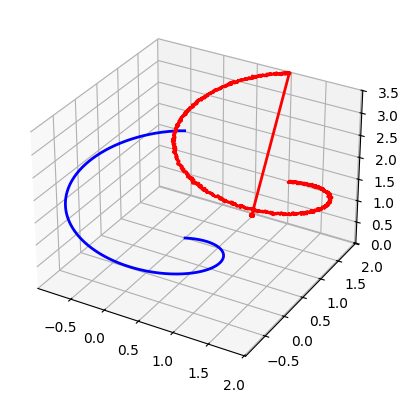

In [220]:
t = np.linspace(0, 1, 1000)
x = np.sin(2 * np.pi * t)  # Signal x coordinate
y = np.cos(2 * np.pi * t)  # Signal y coordinate
z = t / 2 + t * 2  # Signal z coordinate

noise_level = 0.01
t_shifted, x_shifted = shift_signal(t, x, 0.1)
t_shifted, y_shifted = shift_signal(t, y, 0.1)
t_shifted, z_shifted = shift_signal(t, z, 0.1)
x_shifted += 1
y_shifted += 1
z_shifted += 1
x_shifted += noise_level * np.random.randn(x_shifted.shape[0])
y_shifted += noise_level * np.random.randn(y_shifted.shape[0])
z_shifted += noise_level * np.random.randn(z_shifted.shape[0])
# t_shifted = np.concatenate((np.arange()

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
# ax.view_init(-90, 90, 0)
base_shape_plt = ax.plot([], [], [], "b", lw=2)[0]
shifted_shape_plt = ax.plot([], [], [], "r", lw=2)[0]


def init():
    x_min = min(x.min(), x_shifted.min())
    x_max = max(x.max(), x_shifted.max())
    y_min = min(y.min(), y_shifted.min())
    y_max = max(y.max(), y_shifted.max())
    z_min = min(z.min(), z_shifted.min())
    z_max = max(z.max(), z_shifted.max())
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_zlim(z_min, z_max)
    return base_shape_plt, shifted_shape_plt


def update(i):
    base_shape_plt.set_data_3d(np.array([x[:i], y[:i], z[:i]]))
    shifted_shape_plt.set_data_3d(
        np.array([x_shifted[:i], y_shifted[:i], z_shifted[:i]])
    )
    return base_shape_plt, shifted_shape_plt


ani = FuncAnimation(
    fig=fig,
    func=update,
    init_func=init,
    frames=[i for i in range(0, t_shifted.shape[0], 10)],
    blit=True,
    interval=10,
)

HTML(ani.to_html5_video())

In [221]:
mean_mncc = (mncc(x, x_shifted) + mncc(y, y_shifted) + mncc(z, z_shifted)) / 3
print(f"Mean MNCC = {mean_mncc}")
mean_incc = (incc(x, x_shifted) + incc(y, y_shifted) + incc(z, z_shifted)) / 3
print(f"Mean INCC = {mean_incc}")
mean_sbd = (sbd(x, x_shifted) + sbd(y, y_shifted) + sbd(z, z_shifted)) / 3
print(f"Mean SBD = {mean_sbd}")

Mean MNCC = 0.9625353380985971
Mean INCC = 0.9376676566831835
Mean SBD = 0.03746466190140293


Which also works great!

## Bad Sampling

How to do this?

Assumption:

1. The time of each sample is known;
2. The base shape is evenly sampled in time, even if artificially.

Assuming that the time vector $t_b$ is the evenly sampled base time vector. With this we can take the interval
$$
I=t_{b_2}-t_{b_1}
$$,
and create the time vector for the test shape $t_{tr}$ from the unevenly sampled time vector $t_t$ as

$$
t_{tr} = iI\ \forall{i}\ \in\ [0,1,\cdots,n_t]
$$,
where $n_t$ is given by
$$
n_t = \textit{ceil}\left(\frac{t[-1]-t[0]}{I}\right)
$$

Since 1D, 2D and 3D work the same, we'll stick to 1D examples as they're easier to implement

MNCC(x_b, x_t_shifted) = 0.15401604714645806
INCC(x_b, x_t) = 0.15664452097023335


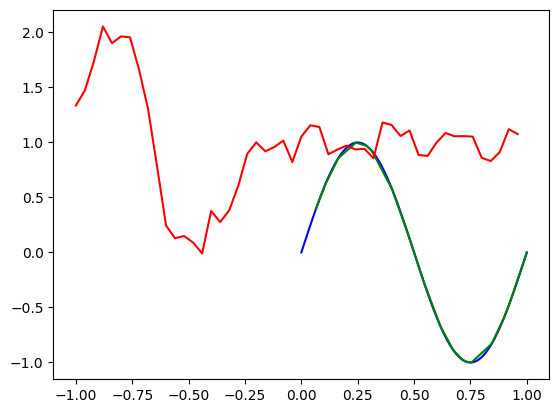

In [222]:
# Simple base signal
t_b = np.linspace(0, 1, 100)
x_b = np.sin(2 * np.pi * t_b)  # Signal x coordinate

# Creating the shifted, noisy, translated, badly sampled signal.
seed = np.cumsum(np.random.rand(20))
t_t = seed / seed[-1] * 1
x_t = np.sin(
    2 * np.pi * t_t
)  # Same generating function as the base signal, sampled in different time points.
t_t_shifted, x_t_shifted = shift_signal(t_t, x_t, 1)  # Shifted signal
# t_t_shifted, x_t_shifted = shift_signal_left(
#     t_t_shifted, x_t_shifted, 0.5
# )  # Shifted signal
x_t_shifted += 1  # Translated signal
x_t_shifted += 0.1 * np.random.randn(x_t_shifted.shape[0])  # Noisy signal

# Let's plot the signals to see how they look like.
plt.plot(t_b, x_b, color="blue")
plt.plot(t_t, x_t, color="green")
plt.plot(t_t_shifted, x_t_shifted, color="red")

# MNCC doesn't work here due to the bad sampling
val = mncc(x_b, x_t_shifted)
print(f"MNCC(x_b, x_t_shifted) = {val}")

# To show this is the we can calculate the MNCC between the blue and green signals,
# which differ only in the time points they were sampled.
val = incc(x_b, x_t)
print(f"INCC(x_b, x_t) = {val}")



The above cell not only creates the signals but shows the ineffectiveness of the proposed approach when the time samples are not correctly dwelt with 

In [223]:
def interpolate_match(t_b, t_t, x_t):
    """
    Interpolates the signal x_t to match the time points of x_b.

    Parameters
    ----------
    t_b : np.ndarray
        Time points of the base signal.
    t_t : np.ndarray
        Time points of the target signal.
    x_t : np.ndarray
        Target signal.

    Returns
    -------
    t_tr : np.ndarray
        Time points of the interpolated signal.
    x_tr : np.ndarray
        Interpolated signal.
    """
    I = t_b[1] - t_b[0]
    nt = np.ceil((t_t[-1] - t_t[0]) / I) + 1
    t_tr = np.linspace(t_t[0], t_t[-1], int(nt))
    x_tr = interpolate.interp1d(t_t, x_t, kind="linear")(t_tr)
    return t_tr, x_tr

INCC(x_b, x_tr) = 0.8682868142496425
MNCC(x_b, x_tr) = 0.891512251025312
SBD(x_b, x_tr) = 0.10848774897468794


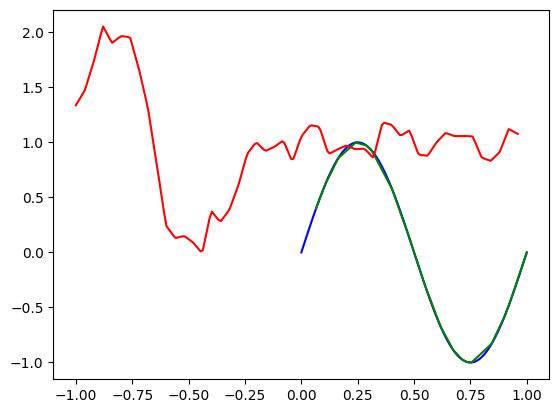

In [224]:
# I = t_b[1] - t_b[0]
# nt = np.ceil((t_t_shifted[-1] - t_t_shifted[0])/ I)
# t_tr = np.linspace(t_t_shifted[0], t_t_shifted[-1], int(nt))
# x_tr = interpolate.interp1d(t_t_shifted, x_t_shifted, kind='cubic')(t_tr)
t_tr, x_tr = interpolate_match(t_b, t_t_shifted, x_t_shifted)

# Let's plot the signals to see how they look like.
plt.plot(t_b, x_b, color="blue")
plt.plot(t_t, x_t, color="green")
plt.plot(t_tr, x_tr, color="red")

val = incc(x_b, x_tr)
print(f"INCC(x_b, x_tr) = {val}")
val = mncc(x_b, x_tr)
print(f"MNCC(x_b, x_tr) = {val}")
val = sbd(x_b, x_tr)
print(f"SBD(x_b, x_tr) = {val}")

Effectively solving the problem

There's still one test!

What if the incoming shape is composed of the base gesture PLUS something else meaningful?

The current implementation experimented here would probably give the bigger error for the smallest similar movement. To illustrate, assume that the gesture for 1 is a movement, then the 11 gesture would not be identified, since the smaller 1 movement gesture would yield a higher correlation. This happens because the maximum correlation is used, what are other options?

I think that the Integrated Normalized cross-correlation should fix that. Let's test!

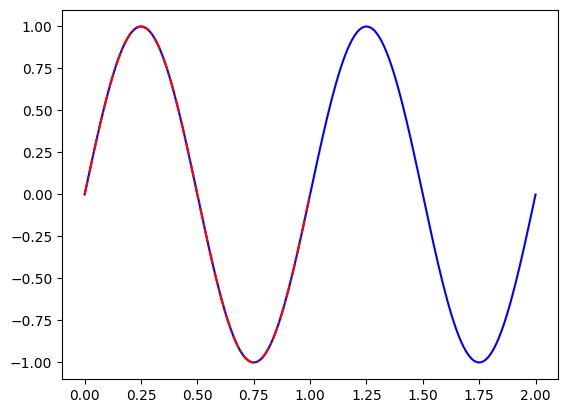

In [227]:
t_bc = np.linspace(0, 2, 200)
x_bc = np.sin(2 * np.pi * t_bc)  # Signal x coordinate
# And some less complex signal
t_b = np.linspace(0, 1, 100)
x_b = np.sin(2 * np.pi * t_b)  # Signal x coordinate
plt.plot(t_bc, x_bc, color="blue")
plt.plot(t_b, x_b, color="red", linestyle="-.")

This could be one example, both red and blue shapes are valid. Blue is composed by two red movements.

INCC(x_bcn, x_bc) = 0.9893100519570078
INCC(x_bn, x_bc) = 0.7114831707086081
INCC(x_bn, x_b = 0.9908357016724737
INCC(x_bcn, x_b = 0.7256481336573176
SBD(x_bcn, x_bc) = 0.011221465522728624
SBD(x_bn, x_bc) = 0.29892902973302493
SBD(x_bn, x_b = 0.008665671232985672
SBD(x_bcn, x_b = 0.300715863316097


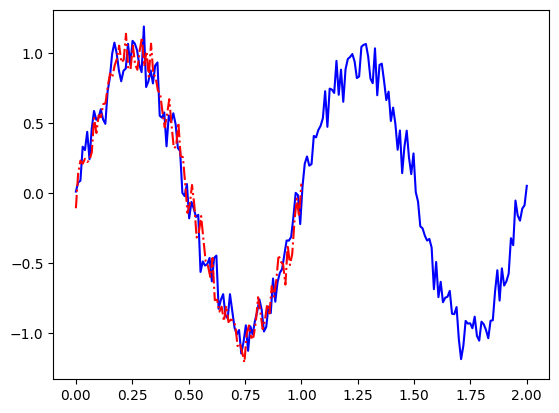

In [228]:
x_bcn = x_bc + 0.1 * np.random.randn(x_bc.shape[0])
x_bn = x_b + 0.1 * np.random.randn(x_b.shape[0])
plt.plot(t_bc, x_bcn, color="blue", linestyle="-")
plt.plot(t_b, x_bn, color="red", linestyle="-.")
print(f"INCC(x_bcn, x_bc) = {incc(x_bcn, x_bc)}")
print(f"INCC(x_bn, x_bc) = {incc(x_bn, x_bc)}")
print(f"INCC(x_bn, x_b = {incc(x_bn, x_b)}")
print(f"INCC(x_bcn, x_b = {incc(x_bcn, x_b)}")
print(f"SBD(x_bcn, x_bc) = {sbd(x_bcn, x_bc)}")
print(f"SBD(x_bn, x_bc) = {sbd(x_bn, x_bc)}")
print(f"SBD(x_bn, x_b = {sbd(x_bn, x_b)}")
print(f"SBD(x_bcn, x_b = {sbd(x_bcn, x_b)}")

Seems like we're ready to try this on real hand movies.

## Test with hand movements

We'll use the hand gestures in the database for this one! The only thing that needs to be done is to add a comparison data for the used gestures.

In [26]:
one_data = pd.read_csv(
    "./gesture_data/ONE_Transcription_Right_Hand.csv",
    parse_dates=True,
)
one_data["time"] = pd.to_datetime(one_data["time"], format="%H:%M:%S.%f")
one_data["time"] = one_data["time"] - one_data["time"][0]
one_data["time"] = one_data["time"].dt.total_seconds()

In [27]:
one_base_ni = []
for index in range(21):
    index_data = one_data[one_data["index"] == index]
    index_data = index_data.sort_values(by="time")
    one_base_ni.append(
        [
            index_data["x"].values,
            index_data["y"].values,
            index_data["z"].values,
            index_data["time"].values,
        ]
    )
one_base_ni = np.array(one_base_ni)
# index finger, [x, y, z, time], time
one_base_ni[0, 0, :]  # all data for index zero, x coordinate

array([0.39504379, 0.38732508, 0.3991532 , 0.40363246, 0.40553761,
       0.406039  , 0.40830779, 0.40973163, 0.41315547, 0.4176037 ,
       0.41975877, 0.42139882, 0.42173964, 0.42171213, 0.42121696,
       0.42003974, 0.41960722, 0.41954699, 0.41967136, 0.41911387,
       0.41840857, 0.41676021, 0.41390386, 0.41163433, 0.40577239,
       0.40320668, 0.39507383, 0.3880353 ])

Interpolates the base gesture so it has evenly spaced samples in time

In [28]:
tb = np.linspace(0, one_base_ni[0, -1, -1], 100)
one_base = []
for index in range(21):
    t_uns = one_base_ni[index, -1, :]
    _, xb = interpolate_match(tb, t_uns, one_base_ni[index, 0, :])
    _, yb = interpolate_match(tb, t_uns, one_base_ni[index, 1, :])
    _, zb = interpolate_match(tb, t_uns, one_base_ni[index, 2, :])
    one_base.append(np.stack((xb, yb, zb, tb), axis=0))
one_base = np.array(one_base)

In [29]:
one_base.shape

(21, 4, 100)

Let's see if the hand is correctly drawn at the first time step

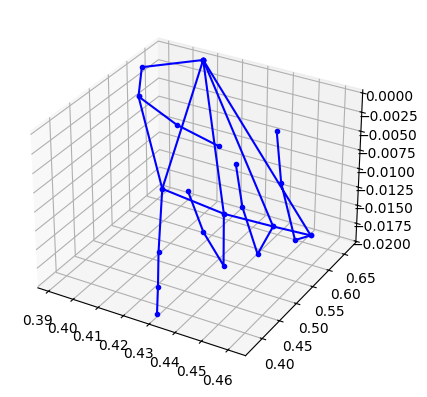

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
limb_connections = {
    "thumb": np.array([0, 1, 2, 3, 4]),
    "index": np.array([0, 5, 6, 7, 8]),
    "middle": np.array([0, 9, 10, 11, 12]),
    "ring": np.array([0, 13, 14, 15, 16]),
    "pinky": np.array([0, 17, 18, 19, 20]),
    "palm": np.array([2, 5, 9, 13, 17]),
    # "sequential": np.arange(0, 21),
}
time = 20
for limb in limb_connections.values():
    ax.plot(
        one_base[limb, 0, time],
        one_base[limb, 1, time],
        one_base[limb, 2, time],
        color="blue",
        marker=".",
    )

# ax.plot(one_base[:,0,0], one_base[:,1,0], one_base[:,2,0], color='red', marker='.')

Show the base gesture video

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


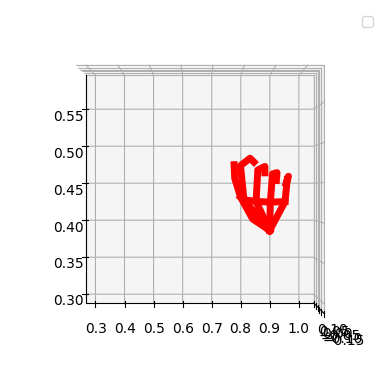

In [304]:
def video_of_hand(data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.view_init(-90, 0, 0)
    xdata, ydata, zdata = [], [], []
    (ln1,) = ax.plot([], [], [], "r", lw=5)
    (ln2,) = ax.plot([], [], [], "r", lw=5)
    (ln3,) = ax.plot([], [], [], "r", lw=5)
    (ln4,) = ax.plot([], [], [], "r", lw=5)
    (ln5,) = ax.plot([], [], [], "r", lw=5)
    (ln6,) = ax.plot([], [], [], "r", lw=5)
    (ln_ref1,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref2,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref3,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref4,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref5,) = ax.plot([], [], [], "b", lw=5)
    (ln_ref6,) = ax.plot([], [], [], "b", lw=5)
    L = plt.legend(loc=1)  # Define legend objects

    def init():
        ax.set_xlim(data[:, 0, :].min() - 0.1, data[:, 0, :].max() + 0.1)
        ax.set_ylim(data[:, 1, :].min() - 0.1, data[:, 1, :].max() + 0.1)
        ax.set_zlim(data[:, 2, :].min() - 0.1, data[:, 2, :].max() + 0.1)
        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )

    def update(i):
        # get the data of each limb
        ln1_data = data[limb_connections["thumb"], :-1, i]
        ln2_data = data[limb_connections["index"], :-1, i]
        ln3_data = data[limb_connections["middle"], :-1, i]
        ln4_data = data[limb_connections["ring"], :-1, i]
        ln5_data = data[limb_connections["pinky"], :-1, i]
        ln6_data = data[limb_connections["palm"], :-1, i]
        # # get the ref data of each limb
        # ln_ref1_data = static_base_points_in_hand_frame[limb_connections["thumb"], :]
        # ln_ref2_data = static_base_points_in_hand_frame[limb_connections["index"], :]
        # ln_ref3_data = static_base_points_in_hand_frame[limb_connections["middle"], :]
        # ln_ref4_data = static_base_points_in_hand_frame[limb_connections["ring"], :]
        # ln_ref5_data = static_base_points_in_hand_frame[limb_connections["pinky"], :]
        # ln_ref6_data = static_base_points_in_hand_frame[limb_connections["palm"], :]
        # Update the data of each limb
        ln1.set_data(ln1_data[:, 0], ln1_data[:, 1])
        ln1.set_3d_properties(ln1_data[:, 2])
        ln2.set_data(ln2_data[:, 0], ln2_data[:, 1])
        ln2.set_3d_properties(ln2_data[:, 2])
        ln3.set_data(ln3_data[:, 0], ln3_data[:, 1])
        ln3.set_3d_properties(ln3_data[:, 2])
        ln4.set_data(ln4_data[:, 0], ln4_data[:, 1])
        ln4.set_3d_properties(ln4_data[:, 2])
        ln5.set_data(ln5_data[:, 0], ln5_data[:, 1])
        ln5.set_3d_properties(ln5_data[:, 2])
        ln6.set_data(ln6_data[:, 0], ln6_data[:, 1])
        ln6.set_3d_properties(ln6_data[:, 2])
        # # Update the ref data of each limb
        # ln_ref1.set_data(ln_ref1_data[:, 0], ln_ref1_data[:, 1])
        # ln_ref1.set_3d_properties(ln_ref1_data[:, 2])
        # ln_ref2.set_data(ln_ref2_data[:, 0], ln_ref2_data[:, 1])
        # ln_ref2.set_3d_properties(ln_ref2_data[:, 2])
        # ln_ref3.set_data(ln_ref3_data[:, 0], ln_ref3_data[:, 1])
        # ln_ref3.set_3d_properties(ln_ref3_data[:, 2])
        # ln_ref4.set_data(ln_ref4_data[:, 0], ln_ref4_data[:, 1])
        # ln_ref4.set_3d_properties(ln_ref4_data[:, 2])
        # ln_ref5.set_data(ln_ref5_data[:, 0], ln_ref5_data[:, 1])
        # ln_ref5.set_3d_properties(ln_ref5_data[:, 2])
        # ln_ref6.set_data(ln_ref6_data[:, 0], ln_ref6_data[:, 1])
        # ln_ref6.set_3d_properties(ln_ref6_data[:, 2])

        return (
            ln1,
            ln2,
            ln3,
            ln4,
            ln5,
            ln6,
            ln_ref1,
            ln_ref2,
            ln_ref3,
            ln_ref4,
            ln_ref5,
            ln_ref6,
        )

    ani = FuncAnimation(
        fig,
        update,
        frames=list(range(data.shape[2])),
        init_func=init,
        blit=True,
        interval=100,
    )

    return HTML(ani.to_html5_video())


# for i in range(one_base.shape[2]):
#     one_base[:, :-1, i] = to_hand_frame(one_base[:, :-1, i])
video_of_hand(one_base)

Now Let's load and compare with another one signal, this time from yt

In [32]:
def to_hand_frame(coordinates: np.array, norm: bool = True) -> np.array:
    """Rotate and translates the coordinates to the hand frame of reference.

    Parameters
    ----------
    coordinates: np.array
        A 2D array containing the coordinates of the points to rotate.
    norm: bool
        A bool indicating if the coordinates should be normalized.

    Returns
    -------
    coordinates_hand_frame: np.array
        A 2D array containing the coordinates of the points in the hand frame of reference.
    """
    coordinates = coordinates.astype(float)
    # The hand frame of reference is obtained by the hand_frame_of_reference function.
    hand_frame = hand_frame_of_reference(coordinates)
    # The rotation matrix is the transpose of the hand frame of reference.
    rotation_matrix = hand_frame.T
    # The coordinates in the hand frame of reference are obtained by multiplying the rotation matrix by the coordinates.
    coordinates_hand_frame = np.zeros_like(coordinates)
    for i in range(coordinates.shape[0]):
        coordinates_hand_frame[i] = np.dot(
            rotation_matrix, coordinates[i] - coordinates[0]
        )
    # for i in range(coordinates.shape[0]):
    #     coordinates_hand_frame[i] = coordinates[i] - coordinates[0]
    if norm:
        # The coordinates are normalized by dividing them by the maximum absolute value of the coordinates.
        coordinates_hand_frame = coordinates_hand_frame / np.abs(
            coordinates_hand_frame
        ).max(axis=0)
    return coordinates_hand_frame

In [302]:
def to_hand_frame_video(coordinates: np.array, norm: bool = True) -> np.array:
    """

    Rotate and translates the coordinates to the hand frame of reference.

    Parameters
    ----------
    coordinates: np.array
        A 2D array containing the coordinates of the points to rotate.
    norm: bool
        A bool indicating if the coordinates should be normalized.

    Returns
    -------
    coordinates_hand_frame: np.array
        A 3D array containing the coordinates of the points in the hand frame of reference.
    """
    coordinates = coordinates.astype(float)
    # The hand frame of reference is obtained by the hand_frame_of_reference function.
    hand_frame = hand_frame_of_reference(coordinates[:, :, 0])
    # The rotation matrix is the transpose of the hand frame of reference.
    rotation_matrix = hand_frame.T
    # The coordinates in the hand frame of reference are obtained by multiplying the rotation matrix by the coordinates.
    coordinates_hand_frame = np.zeros_like(coordinates)
    for i in range(coordinates.shape[2]):
        for j in range(coordinates.shape[0]):
            coordinates_hand_frame[j, :, i] = np.dot(
                rotation_matrix, coordinates[j, :, i] - coordinates[0, :, 0]
            )
    if norm:
        coordinates_hand_frame = norm_hand(coordinates_hand_frame)
    return coordinates_hand_frame

def norm_hand(coordinates_hand_frame: np.array) -> np.array:
    """
    Normalize the coordinates in the hand frame of reference.

    Parameters
    ----------
    coordinates_hand_frame: np.array
        A 2D array containing the coordinates of the points in the hand frame of reference.

    Returns
    -------
    coordinates_hand_frame: np.array
        A 2D array containing the normalized coordinates of the points in the hand frame of reference.
    """
    # The coordinates are normalized by dividing them by the maximum absolute value of the coordinates.
    # max_val = np.abs(coordinates_hand_frame).max(axis=0).max(axis=1)
    # for i in range(coordinates_hand_frame.shape[0]):
    #     for j in range(coordinates_hand_frame.shape[2]):
    #         coordinates_hand_frame[i, :, j] = coordinates_hand_frame[i, :, j] / max_val
    for i in range(coordinates_hand_frame.shape[2]):
        coordinates_hand_frame[:, :, i] = coordinates_hand_frame[:, :, i] / np.abs(
            coordinates_hand_frame[:, :, i]
        ).max(axis=0)
    # coordinates_hand_frame = coordinates_hand_frame / np.abs(
    #     coordinates_hand_frame
    # ).max(axis=0)
    return coordinates_hand_frame
    

In [327]:
def get_data_in_time(one_data_test, tb, time, hand_frame=False, norm_only=False):
    one_data_test = one_data_test.copy()
    one_data_test["time"] = pd.to_datetime(one_data_test["time"], format="%H:%M:%S.%f")
    one_data_test["time"] = one_data_test["time"] - one_data_test["time"][0]
    one_data_test["time"] = one_data_test["time"].dt.total_seconds()
    # Filter to get only the data of the one signal
    if time is not None:
        one_data_test = one_data_test[one_data_test["time"] >= time[0]]
        one_data_test = one_data_test[one_data_test["time"] <= time[1]]
        one_data_test["time"] = one_data_test["time"] - one_data_test["time"].iloc[0]
    # And transform it to the same shape as the one_base
    one_test_ni = []
    for index in range(21):
        index_data = one_data_test[one_data_test["index"] == index]
        index_data = index_data.sort_values(by="time")
        one_test_ni.append(
            [
                index_data["x"].values,
                index_data["y"].values,
                index_data["z"].values,
                index_data["time"].values,
            ]
        )
    one_test_ni = np.array(one_test_ni)
    # index finger, [x, y, z, time], time
    one_test_ni[0, 0, :]  # all data for index zero, x coordinate
    # tb = one_base[0, -1, :]
    one_test = []
    for index in range(21):
        t_uns = one_test_ni[index, -1, :]
        _, xb = interpolate_match(tb, t_uns, one_test_ni[index, 0, :])
        _, yb = interpolate_match(tb, t_uns, one_test_ni[index, 1, :])
        t_t, zb = interpolate_match(tb, t_uns, one_test_ni[index, 2, :])
        one_test.append(np.stack((xb, yb, zb, t_t), axis=0))
    one_test = np.array(one_test)
    if hand_frame:
        # for i in range(one_test.shape[2]):
        #     one_test[:, :-1, i] = to_hand_frame(one_test[:, :-1, i])
        one_test[:, :-1] = to_hand_frame_video(one_test[:, :-1], norm=False)
    if norm_only == True:
        one_test[:, :-1] = norm_hand(one_test[:, :-1])
    return one_test

In [231]:
one_data_test = pd.read_csv(
    "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
    parse_dates=True,
)

And generate the video to compare

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


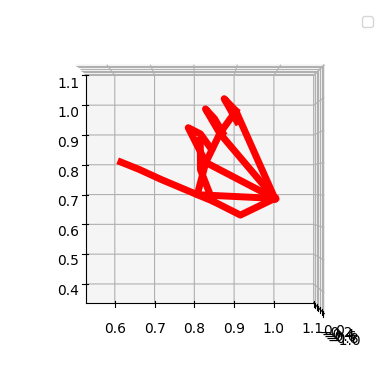

In [305]:
one_test = get_data_in_time(one_data_test, one_base[0, -1, :], [4, 6.3], norm_only=True)
# Rotate data
# for i in range(one_test.shape[2]):
#     one_test[:, :-1, i] = to_hand_frame(one_test[:, :-1, i])
video_of_hand(one_test)

And now the function that compares the two movements using the cross-correlation

In [37]:
def compare_cross_corr(base_data, incoming_data):
    """
    Compare the cross correlation between the base data and the incoming data.

    Parameters
    ----------
    base_data : np.ndarray
        Base data.
    incoming_data : np.ndarray
        Incoming data.

    Returns
    -------
    np.ndarray
        Mean INCC between the base data and the incoming data.
    """
    mean_incc = 0
    for i in range(base_data.shape[0]):
        for j in range(base_data.shape[1] - 1):
            mean_incc += mncc(base_data[i, j, :], incoming_data[i, j, :])
    return mean_incc / (base_data.shape[0] * (base_data.shape[1] - 1))

And the mean INNC are

In [38]:
print(f"Mean INCC = {compare_cross_corr(one_base, one_test)}")
print(f"Sanity check. Mean INCC = {compare_cross_corr(one_base, one_base)}")

Mean INCC = 0.47373272371017366
Sanity check. Mean INCC = 1.0


Now let's compare the one_base movement gesture with the two movement gesture to see what happens.

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


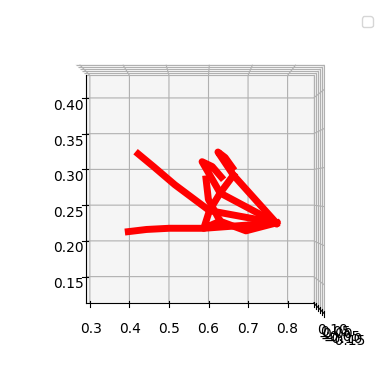

In [39]:
# one_data_test = pd.read_csv(
#     "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
#     parse_dates=True,
# )
# two_test = get_data_in_time(one_data_test, one_base[0, -1, :], [6.5, 7.8])
two_data = pd.read_csv(
    "./gesture_data/TWO_Transcription_Right_Hand.csv",
    parse_dates=True,
)
two_test = get_data_in_time(two_data, one_base[0, -1, :], None)
# Rotate data
# for i in range(two_test.shape[2]):
#     two_test[:, :-1, i] = to_hand_frame(two_test[:, :-1, i])
video_of_hand(two_test)

The INCC between the base one and the two is

In [40]:
print(f"Mean INCC = {compare_cross_corr(one_base, two_test)}")
print(f"Sanity check. Mean INCC = {compare_cross_corr(one_base, one_test)}")

Mean INCC = 0.43942566486537565
Sanity check. Mean INCC = 0.47373272371017366


Needs more testing, the difference is not as big as I would like!

Can we use the Spearman rank-order correlation coefficient?

In [41]:
print(one_base.shape)
print(one_test.shape)

(21, 4, 100)
(21, 4, 125)


In [42]:
stats.spearmanr(one_base[0, 0, :], one_base[0, 0, :])

SignificanceResult(statistic=0.9999999999999999, pvalue=0.0)

In [43]:
def compare_spearman(base_data, incoming_data):
    """
    Compare the cross correlation between the base data and the incoming data.

    Parameters
    ----------
    base_data : np.ndarray
        Base data.
    incoming_data : np.ndarray
        Incoming data.

    Returns
    -------
    np.ndarray
        Mean INCC between the base data and the incoming data.
    """
    mean_incc = 0
    for i in range(base_data.shape[0]):
        for j in range(base_data.shape[1] - 1):
            mean_incc += stats.spearmanr(base_data[i, j, :], incoming_data[i, j, :])
    return mean_incc / (base_data.shape[0] * (base_data.shape[1] - 1))

## Shape-Based distance (SBD)

Shape-based distance is a distance metric that measures the shape distance of two time series. See [k-Shape: Efficient and Accurate Clustering of Time Series](https://sigmodrecord.org/publications/sigmodRecord/1603/pdfs/18_kShape_RH_Paparrizos.pdf), which uses the SBD metric to cluster time-series data. For our objectives, the metric and its definition is enough. The SBD is defined, for sequence vectors $\overrightarrow{x}$ and $\overrightarrow{y}$, as
$$
SBD(\overrightarrow{x},\overrightarrow{y}) = 1 - \max_{w} \left(\frac{CC_w(\overrightarrow{x},\overrightarrow{y})}{\sqrt{R_0(\overrightarrow{x},\overrightarrow{x})R_0(\overrightarrow{y},\overrightarrow{y})}}\right)
$$
where $R_0(\overrightarrow{x},\overrightarrow{y})$ is defined as
$$
R_0 = \sum_{l=1}^{m} x_ly_l
$$

This can be written in terms of the norm of both vectors as
$$
SBD(\overrightarrow{x},\overrightarrow{y}) = 1 - \max_{w} \left(\frac{CC_w(\overrightarrow{x},\overrightarrow{y})}{||\overrightarrow{x}||_2||\overrightarrow{y}||_2}\right)
$$

With those definitions, the SBD metric can be implemented as follows

In [338]:
def sbd(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Signal based distance (SBD) between two signals.

    Parameters
    ----------
    a : np.ndarray
        First signal.
    b : np.ndarray
        Second signal.

    Returns
    -------
    sbd : float
    """
    a = (a - np.mean(a)) / np.std(a)
    b = (b - np.mean(b)) / np.std(b)
    # a = a / a.max()
    # b = b / b.max()
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        norm_corr = 0
    else:
        norm_corr = np.correlate(a, b, mode="full") / (
            np.linalg.norm(a) * np.linalg.norm(b)
        )
    return 1 - np.max(np.abs(norm_corr))

And to compare a hand using SDB

In [45]:
def compare_sbd(base_data, incoming_data):
    """
    Give the SBD between base hand data and the incoming data.

    Parameters
    ----------
    base_data : np.ndarray
        Base data.
    incoming_data : np.ndarray
        Incoming data.

    Returns
    -------
    np.ndarray
        Mean SBD between the base hand data and the incoming data.
    """
    mean_sbd = 0
    for i in range(base_data.shape[0]):
        for j in range(base_data.shape[1] - 1):
            mean_sbd += sbd(base_data[i, j, :], incoming_data[i, j, :])
    return mean_sbd / (base_data.shape[0] * (base_data.shape[1] - 1))
    # max_sbd = 0
    # for i in range(base_data.shape[0]):
    #     for j in range(base_data.shape[1] - 1):
    #         max_sbd = max(max_sbd, sbd(base_data[i, j, :], incoming_data[i, j, :]))
    # return max_sbd
    # avg_base = np.mean(base_data, axis=0)
    # avg_incoming = np.mean(incoming_data, axis=0)
    # result = 0
    # for i in range(avg_base.shape[0] - 1):
    #     result += sbd(avg_base[i, :], avg_incoming[i, :])
    # return result / (avg_base.shape[0] - 1)
    # mean_sbd = 0
    # for i in range(base_data.shape[0]):
    #     for j in range(base_data.shape[1] - 2):
    #         mean_sbd += sbd(base_data[i, j, :], incoming_data[i, j, :])
    # return mean_sbd / (base_data.shape[0] * (base_data.shape[1] - 2))

In [46]:
def compare_dtw(base_data, incoming_data, metric="euclidean"):
    """
    Compare the dtw between the base data and the incoming data.

    Parameters
    ----------
    base_data : np.ndarray
        Base data.
    incoming_data : np.ndarray
        Incoming data.
    
    Returns
    -------
    float
        Mean dtw between the base data and the incoming data.
    """
    mean_dtw = 0
    for i in range(base_data.shape[0]):
        _ , cost = dtw_path_from_metric(base_data[i, :-1, :].T, incoming_data[i, :-1, :].T, metric=metric)
        mean_dtw += cost
        # mean_dtw += dtw(base_data[i, :-1, :].T, incoming_data[i, :-1, :].T)
    return mean_dtw / (base_data.shape[0])

What does this gives for the one gesture test?

In [47]:
print(f"Mean sdb = {compare_sbd(one_base, two_test)}")
print(f"Sanity check. Mean sdb with test = {compare_sbd(one_base, one_test)}")
print(f"Sanity² check. Mean sdb with itself = {compare_sbd(one_base, one_base)}")

Mean sdb = 0.4114403710586235
Sanity check. Mean sdb with test = 0.42982880856415495
Sanity² check. Mean sdb with itself = -3.172065784643304e-17


Which work as intended. The first case, which compares the one gesture with the two gesture, gives a higher number, comparing the one_base with the one_test gives a smaller number and comparing it against itself gives zero.

Let's use the SBD metric to compare against all other numbers (up to 10)

In [48]:
data_numbers = pd.read_csv(
    "./gesture_data/ONE_YT_2_Transcription_Right_Hand.csv",
    parse_dates=True,
)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


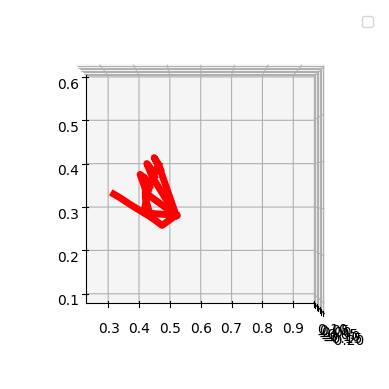

In [49]:
one_test = get_data_in_time(data_numbers, one_base[0, -1, :], [4, 6.3])
video_of_hand(one_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


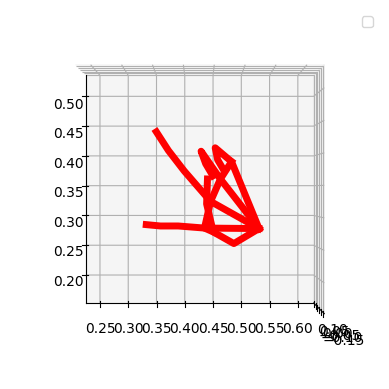

In [50]:
two_test = get_data_in_time(data_numbers, one_base[0, -1, :], [6.3, 7])
video_of_hand(two_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


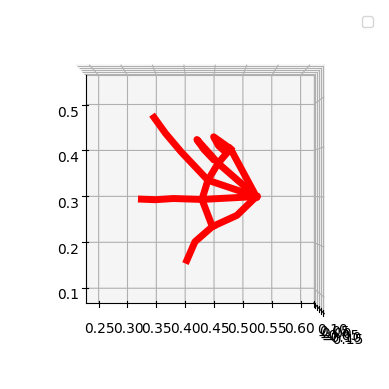

In [51]:
three_test = get_data_in_time(data_numbers, one_base[0, -1, :], [7.7, 8.5])
video_of_hand(three_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


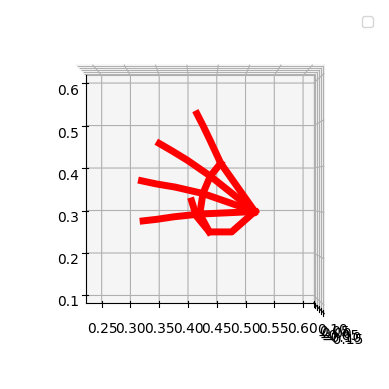

In [52]:
four_test = get_data_in_time(data_numbers, one_base[0, -1, :], [9, 10])
video_of_hand(four_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


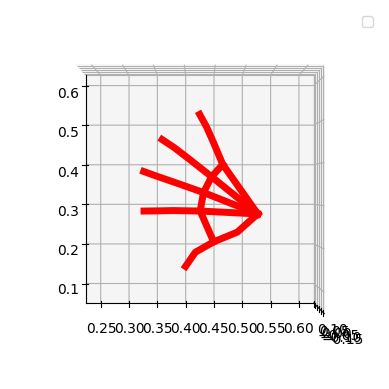

In [53]:
five_test = get_data_in_time(data_numbers, one_base[0, -1, :], [10, 11.5])
video_of_hand(five_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


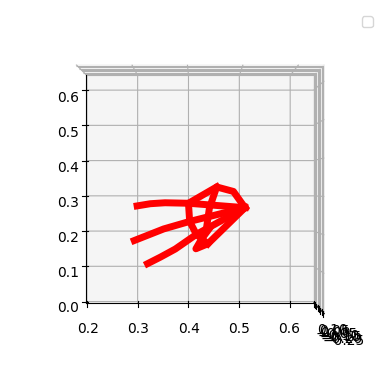

In [54]:
six_test = get_data_in_time(data_numbers, one_base[0, -1, :], [12, 14])
video_of_hand(six_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


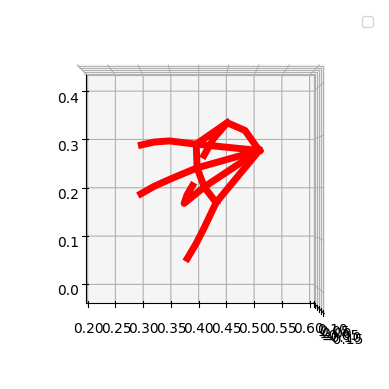

In [55]:
seven_test = get_data_in_time(data_numbers, one_base[0, -1, :], [15, 16])
video_of_hand(seven_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


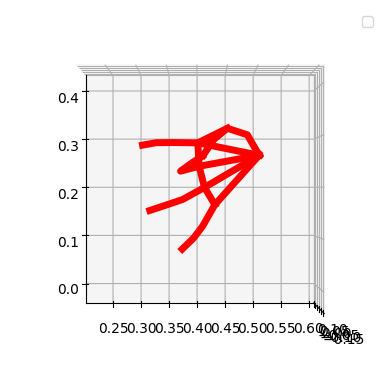

In [56]:
eight_test = get_data_in_time(data_numbers, one_base[0, -1, :], [16, 17])
video_of_hand(eight_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


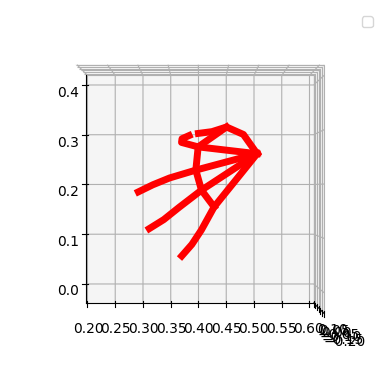

In [57]:
nine_test = get_data_in_time(data_numbers, one_base[0, -1, :], [17, 18])
video_of_hand(nine_test)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


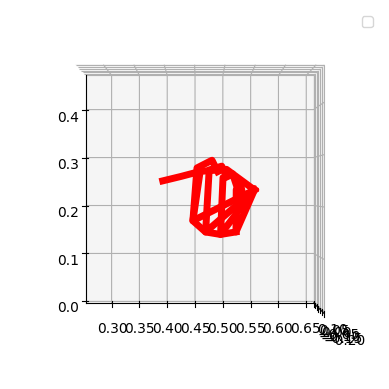

In [58]:
ten_test = get_data_in_time(data_numbers, one_base[0, -1, :], [22, 24])
video_of_hand(ten_test)

#### And now let's run the comparison of ten with each number movement
Note: although numbers one to nine can be identified by static gestures, this test is made using the "videos". It only makes sense in testing.

In [59]:
test_videos = [
    one_test,
    two_test,
    three_test,
    four_test,
    five_test,
    six_test,
    seven_test,
    eight_test,
    nine_test,
    ten_test,
]
for i, test in enumerate(test_videos):
    print(f"Mean SBD with test {i+1} = {compare_sbd(ten_test, test)}")

Mean SBD with test 1 = 0.36973970183370636
Mean SBD with test 2 = 0.38890214984245736
Mean SBD with test 3 = 0.4052237841388793
Mean SBD with test 4 = 0.35685607907774036
Mean SBD with test 5 = 0.32859211459484794
Mean SBD with test 6 = 0.28773273803347804
Mean SBD with test 7 = 0.44677042075850315
Mean SBD with test 8 = 0.3929060437947659
Mean SBD with test 9 = 0.3370189784716336
Mean SBD with test 10 = -8.811293846231401e-17


Let's test ten against other movement gestures, like 11, 12, 13, 14, 15, J and Z

In [339]:
base = [
    "ELEVEN",
    "TWELVE",
    "THIRTEEN",
    "FOURTEEN",
    "FIFTEEN",
    "SIXTEEN",
    "SEVENTEEN",
    "EIGHTEEN",
    "NINETEEN",
    "TWENTY",
    "J",
    "Z",
]
base_data = [
    get_data_in_time(
        pd.read_csv(
            f"./gesture_data/{test}_Transcription_Right_Hand.csv", parse_dates=True
        ),
        np.linspace(0, 1, 100),
        None,
        hand_frame=True,
        norm_only=False,
    )
    for test in base
]

In [340]:
tests = [
    "ELEVEN_1",
    "TWELVE_1",
    "THIRTEEN_1",
    "FOURTEEN_1",
    "FIFTEEN_1",
    "SIXTEEN_1",
    "SEVENTEEN_1",
    "EIGHTEEN_1",
    "NINETEEN_1",
    "TWENTY_1",
    "J_1",
    "Z_1",
]
test_data = [
    get_data_in_time(
        pd.read_csv(
            f"./gesture_data/{test}_Transcription_Right_Hand.csv",
            parse_dates=True,
        ),
        np.linspace(0, 1, 100),
        None,
        hand_frame=True,
        norm_only=False,
    )
    for test in tests
]
# The below code shows that the method can in fact deal with a lot of white noise.
# test_data = [data + 0.05*np.random.rand(data.shape[0],data.shape[1],data.shape[2]) for data in base_data]
# for i, test in enumerate(test_data):
#     test_data[i][:, -1] = base_data[i][:, -1]

In [330]:
test_data[0].shape

(21, 4, 263)

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


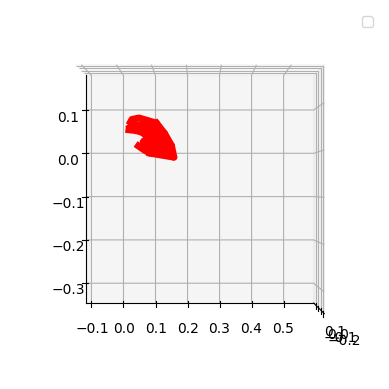

In [331]:
video_of_hand(base_data[-1])

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


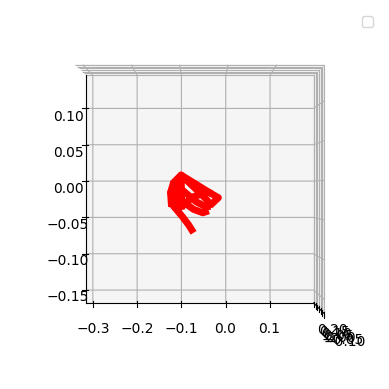

In [337]:
video_of_hand(test_data[-2])

In [341]:
# metrics = [
#     "minkowski",
#     # "matching",
#     # "sokalsneath",
#     # "rogerstanimoto",
#     # "precomputed",
#     # "cosine",
#     # "correlation",
#     "euclidean",
#     "cityblock",
#     # "russellrao",
#     "manhattan",
#     # "sokalmichener",
#     # "sqeuclidean",
#     # "hamming",
#     # "yule",
#     "l2",
#     "l1",
#     # "dice",
#     # "braycurtis",
#     # "jaccard",
#     # "chebyshev",
#     "canberra",
# ]
# for metric in metrics:
#     print(f"Using metric {metric}")
#     for j in range(len(base_data)):
#         dtw_scores = []
#         for i, test in enumerate(test_data):
#             dtw_scores.append(compare_dtw(base_data[j], test, metric=metric))
#         min_dtw_index = np.argmin(dtw_scores)
#         print(f"Identifyed {tests[min_dtw_index]} as {base[j]}")
#         print("\n")
for j in range(len(base_data)):
        dtw_scores = []
        for i, test in enumerate(test_data):
            dtw_scores.append(compare_sbd(base_data[j], test))
            print(f"Comparing {base[j]} with {tests[i]}, SBD = {dtw_scores[-1]}")
        min_dtw_index = np.argmin(dtw_scores)
        print(f"Identifyed {tests[min_dtw_index]} as {base[j]}")
        print("\n")
# for j in range(len(base_data)):
#     dtw_scores = []
#     for i, test in enumerate(test_data):
#         dtw_scores.append(compare_cross_corr(base_data[j], test))
#     min_dtw_index = np.argmin(dtw_scores)
#     print(f"Identifyed {tests[min_dtw_index]} as {base[j]}")
#     print("\n")

Comparing ELEVEN with ELEVEN_1, SBD = 0.40773534576427567
Comparing ELEVEN with TWELVE_1, SBD = 0.48659844056788365
Comparing ELEVEN with THIRTEEN_1, SBD = 0.5539592125397907
Comparing ELEVEN with FOURTEEN_1, SBD = 0.43739439604989283
Comparing ELEVEN with FIFTEEN_1, SBD = 0.5306594230531232
Comparing ELEVEN with SIXTEEN_1, SBD = 0.5118831861917188
Comparing ELEVEN with SEVENTEEN_1, SBD = 0.576957941882939
Comparing ELEVEN with EIGHTEEN_1, SBD = 0.4564304860864643
Comparing ELEVEN with NINETEEN_1, SBD = 0.5151127175716946
Comparing ELEVEN with TWENTY_1, SBD = 0.5102447537118545
Comparing ELEVEN with J_1, SBD = 0.41972413166693084
Comparing ELEVEN with Z_1, SBD = 0.5147650055147954
Identifyed ELEVEN_1 as ELEVEN


Comparing TWELVE with ELEVEN_1, SBD = 0.45954231340028656
Comparing TWELVE with TWELVE_1, SBD = 0.49714959801957925
Comparing TWELVE with THIRTEEN_1, SBD = 0.5249615644901136
Comparing TWELVE with FOURTEEN_1, SBD = 0.4108847575371616
Comparing TWELVE with FIFTEEN_1, SBD = 0.497

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


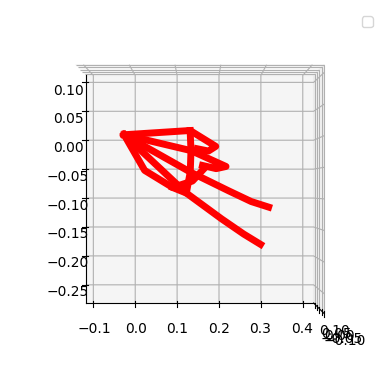

In [334]:
video_of_hand(base_data[1])

/tmp/ipykernel_36775/227790054.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  L = plt.legend(loc=1)  # Define legend objects


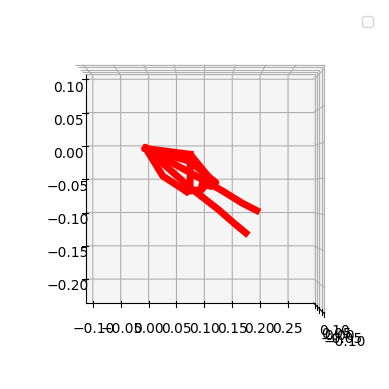

In [335]:
video_of_hand(test_data[1])

This is not working well, perhaps it is important to create a reference frame for the video?